<a href="https://colab.research.google.com/github/ikonushok/AI-Traiding/blob/main/Pivot_points_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading libraries

In [1]:
from IPython.display import clear_output

In [2]:
# Загрузка библиотек ai_tr_libs с github
#!curl --remote-name --location https://raw.githubusercontent.com/chekh/ai_tr_libs/main/make_y.py
#!curl --remote-name --location https://raw.githubusercontent.com/chekh/ai_tr_libs/main/dataloader.py
!curl --remote-name --location https://raw.githubusercontent.com/chekh/ai_tr_libs/main/Long_n_short_strategy.py
!curl --remote-name --location https://raw.githubusercontent.com/chekh/ai_tr_libs/main/Long_strategy.py
#!curl --remote-name --location https://raw.githubusercontent.com/chekh/ai_tr_libs/main/Dataset.py
clear_output()

In [3]:
!pip install backtesting
clear_output()

In [4]:
!pip install tulipy
clear_output()

# Подключение библиотек

In [5]:
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import utils

#from keras.utils import to_categorical

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder, OneHotEncoder # проверить все

from keras.preprocessing.sequence import TimeseriesGenerator

# Библиоетки backtesting
from backtesting import Backtest, Strategy

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from pandas import DataFrame as df

#import tulipy as tl

#from tensorflow.keras import backend as K

# Библиотеки из ai_tr_libs
#from make_y import Super_Dooper
#from dataloader import Dataloader as dl
from Long_n_short_strategy import Long_n_Short_Strategy as LnS
from Long_strategy import Long_Strategy as LS
#from Dataset import Dataset

/usr/local/lib/python3.7/dist-packages/backtesting/_plotting.py:45: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


# Data preparing

In [23]:
ticker = 'POLY.ME'
test_window = 220
val_window = 700
batch_size = 100 # должен быть больше test_window
ensemble = 40

## Load dataset

In [24]:
import time
# Загрузка только [Open, High, Low, Close]
data = pd.read_csv('/content/drive/MyDrive/AI_Trading/AI-trading_courses/4. НС и торговля по паттернам/Подбор оптимальных параметров/outputs/signalsPOLY.ME_1h.csv', sep="\t")#, header=None)
data.columns=['Date', 'Open', 'High', 'Low', 'Close', 'Signal']

# Удаляем наниты
data.dropna(axis=0, inplace=True)
data = data.reset_index(drop=True)
data.Date = pd.to_datetime(data.Date).dt.strftime("%Y-%m-%d %H:%M")
data.Date = pd.to_datetime(data.Date)
data['Datetime'] = data['Date']
data.set_index('Datetime', inplace=True)
print(data.shape)
data

(3556, 6)


,Date,Open,High,Low,Close,Signal
Datetime,,,,,,
2020-01-03 13:30:00,2020-01-03 13:30:00,983.000000,988.599976,982.799988,986.400024,-1.0
2020-01-03 14:30:00,2020-01-03 14:30:00,986.000000,987.299988,984.700012,985.700012,-1.0
2020-01-03 15:30:00,2020-01-03 15:30:00,985.700012,986.799988,980.799988,981.299988,1.0
2020-01-03 16:30:00,2020-01-03 16:30:00,980.900024,985.000000,980.500000,981.500000,1.0
2020-01-03 17:30:00,2020-01-03 17:30:00,982.200012,987.500000,981.000000,985.200012,1.0
...,...,...,...,...,...,...
2021-06-04 14:30:00,2021-06-04 14:30:00,1728.800049,1731.199951,1724.900024,1725.099976,1.0
2021-06-04 15:30:00,2021-06-04 15:30:00,1725.199951,1759.800049,1725.199951,1755.400024,1.0
2021-06-04 16:30:00,2021-06-04 16:30:00,1756.000000,1759.900024,1753.900024,1759.000000,1.0


Text(0.5, 1.0, 'График цены на POLY.ME (1h)')

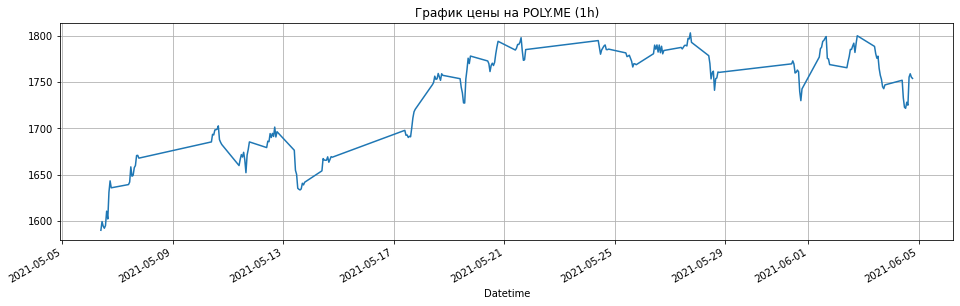

In [25]:
plt.figure(figsize=(16,6))
ax0 = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
#ax1 = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4)
data['Close'][-220:].plot(ax = ax0)
plt.grid()
plt.title('График цены на ' + ticker + ' (1h)')
#data[indicator_name].plot(ax = ax1)

## Train, Val, Test датасет генераторы

In [26]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder, OneHotEncoder 
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import pandas as pd
import numpy as np
#from pandas import DataFrame as df


class Dataset():
  def __init__(self, dataset, batch_size, ensemble, one_hot_enc=True, dropna=False, drop_signal=False, date_to_feat=False, **kwargs):
    '''
    Пример использования
    data - DataFrame(ohlc)
    
    ds = Dataset(data, 1, 10, test_start_index=14900, test_end_index=15000, one_hot_enc=True, stride=2, sampling_rate=2)
    model.fit(ds.train())
    
    ddd = ds.test_prep_dec(np.array(np.random.randint(-1,2,(40,2))))
    
    ds.y_encoder.inverse_transform([[1.,0.]])
    ds.test()[0]


    Параметры TimeSeriesGenerator:
    data: Индексируемый генератор (например, массив List или Numpy), содержащий последовательные точки данных (временные интервалы). 
    Данные должны иметь размерность 2D, а ось 0 должна быть измерением времени.
    
    targets: Целевые значения, соответствующие временному интервалу в данных. Они должны иметь ту же длину, что и данные.
    
    length: Длина выходных последовательностей (по количеству временных интервалов).
    
    sampling_rate: Период между последовательными отдельными временными шагами внутри последовательностей. 
    Для скорости r, временной шаг data[i], data[i-r], … data[i — длина] используется для создания последовательности дискретизации.
    
    stride: Период между последовательными выходными последовательностями. Для шага s последовательные выходные выборки будут центрироваться вокруг данных[i], 
    данных[i+s], данных[i+2*s] и др.
    
    start_index: Точки данных предшествующие start_index, не будут использоваться в выходных последовательностях. 
    Это полезно для резервирования части данных для тестирования или валидации.
    
    end_index: Точки данных, расположенные позже, чем end_index, не будут использоваться в выходных последовательностях. 
    Это полезно для резервирования части данных для тестирования или проверки.
    
    shuffle: Следует ли тасовать выходные выборки, или вместо этого располагать их в хронологическом порядке.
    
    reverse: Boolean: если верно, то таймфреймы в каждой выходной выборке будут в обратном хронологическом порядке.
    
    batch_size: Количество сэмплов таймсерий в каждой партии (за исключением, возможно, последней).
    '''
    
    self.featurized = False
    self.data = dataset
    self.batch_size = batch_size
    self.ensemble = ensemble
    self.dropna = dropna
    self.one_hot_enc = one_hot_enc
    self.shape = self.data.shape
    self.drop_signal = drop_signal
    self.date_to_feat = date_to_feat

    self.training_start_index = 0 if 'training_start_index' not in kwargs.keys() else kwargs['training_start_index']
    self.val_start_index = 0 if 'val_start_index' not in kwargs.keys() else kwargs['val_start_index']
    self.test_start_index = 0 if 'test_start_index' not in kwargs.keys() else kwargs['test_start_index']
    self.training_end_index = self.shape[0] - 1 if 'training_end_index' not in kwargs.keys() else kwargs['training_end_index']
    self.val_end_index = self.shape[0] - 1 if 'val_end_index' not in kwargs.keys() else kwargs['val_end_index']
    self.test_end_index = self.shape[0] - 1 if 'test_end_index' not in kwargs.keys() else kwargs['test_end_index']
    
    self.stride = 1 if 'strid' not in kwargs.keys() else kwargs['stride']
    self.sampling_rate = 1 if 'sampling_rate' not in kwargs.keys() else kwargs['sampling_rate']

    self.featurize()


  def featurize(self):
    '''
    Формирвоание X разметки и скалирование X и y
    '''
    if self.one_hot_enc:
      self.one_hot_encode_y()

    temp = self.data.copy()
    
    if self.date_to_feat:
      date = pd.to_datetime(temp['Date'], format='%Y%m%d')
      temp['week_day'] = date.apply(lambda x: x.weekday())
      temp['month'] = date.apply(lambda x: x.month)
      temp['week'] = date.apply(lambda x: x.week)
      temp['day'] = date.apply(lambda x: x.day)
      
    #temp.drop(['Ticker', 'Per', 'Date', 'Time'], axis=1, inplace=True)
    temp.drop(['Date'], axis=1, inplace=True)
    if self.drop_signal:
      temp.drop(['Signal'], axis=1, inplace=True)
    temp['sin'] = temp['Close'].apply(lambda x: np.sin(x))
    
    if self.dropna:
      temp.dropna(axis=0, inplace=True)

    self.data_before_scaling = temp
    
    xScaler = RobustScaler()
    self.X = xScaler.fit_transform(temp)

    self.input_shape = (self.ensemble, self.X.shape[1])

    self.featurized = True


  def one_hot_encode_y(self):
    '''
    one_hot_encoder для y
    '''
    self.y = self.data['Signal'].copy().to_numpy().reshape(-1,1)
    self.y_encoder = OneHotEncoder().fit(self.y)
    self.y = self.y_encoder.transform(self.y).toarray()


  def __ts(self, start_index, end_index):
    assert self.featurized, 'Dataset is not featuarized yet, perform Dataset.featurize()!'
    return TimeseriesGenerator(self.X, self.y, length=self.ensemble, stride=self.stride, sampling_rate=self.sampling_rate, 
                              start_index=start_index, end_index=end_index, 
                              batch_size=self.batch_size)


  def train(self, start_index=None, end_index=None):
    '''
    TimeSeriesGenerator для train датасета
    '''
    start = (self.training_start_index, start_index)[start_index != None]
    end = (self.training_end_index, end_index)[end_index != None]
    assert self.featurized, 'Dataset is not featuarized yet, perform Dataset.featurize()!'
    return self.__ts(start, end)


  def val(self, start_index=None, end_index=None):
    '''
    TimeSeriesGenerator для val датасета
    '''
    start = (self.val_start_index, start_index)[start_index != None]
    end = (self.val_end_index, end_index)[end_index != None]
    assert self.featurized, 'Dataset is not featuarized yet, perform Dataset.featurize()!'
    return self.__ts(start, end)


  def test(self, start_index=None, end_index=None):
    '''
    TimeSeriesGenerator для test датасета
    '''
    start = (self.test_start_index, start_index)[start_index != None]
    end = (self.test_end_index, end_index)[end_index != None]
    assert self.featurized, 'Dataset is not featuarized yet, perform Dataset.featurize()!'
    return self.__ts(start, end)


  def test_prep_dec(self, prep):
    '''
    Decoding предикта в исходный формат y
    '''
    assert self.featurized, 'Dataset is not featuarized yet, perform Dataset.featurize()!'
    assert self.test_end_index + 1 - self.test_start_index - self.ensemble == prep.shape[0], 'Length of prediction is not equal length of source data.'
    if self.one_hot_enc:
      prep = self.y_encoder.inverse_transform(prep)
    else:
      assert prep.shape[1] == 1, 'Wrong shape dimension of predicted data.'
    res = df() 
    res = self.data[['Open', 'High', 'Low', 'Close']][self.test_start_index + self.ensemble: self.test_end_index + 1].copy()
    res['Signal'] = prep
    return res

In [27]:
# Создаем экземпляр класса Dataset на базе входных данных с размеченным y 
# при создании указываем размер batch_size и ensemble, по умолчанию y будет преобразован в one_hot_encoded вектор
ds = Dataset(data, batch_size, ensemble)

# Устанавливаем границы test, val и train датасетов 
# В классе 6 параметров - m_start_index, m_end_index, где m = {train, val, test} 
# По умолчанию начало каждого датасета равно 0 а конец - крайний элемент в массиве
# Вычитаем из хвоста размер тестового датасета - получаем его начало, 
# вычитаем от начала test датасет 1 - получаем конец val датасета
# Аналогично для train
ds.test_start_index = ds.test_end_index - test_window - ensemble
ds.val_end_index = ds.test_start_index - 1
ds.val_start_index = ds.val_end_index - val_window - test_window - ensemble
ds.train_end_index = ds.val_start_index - 1

# Установленное значение ensemble удобно использовать для инициализации других переменных,
# ниже инициализация переменной для конфигурации сети
ensemble = ds.ensemble

In [28]:
#ds.data_before_scaling

# Neural Networks

## Сеть

In [29]:
""" обьединим все сети """

drop = 0.4

## входной слой
#input_layer = Input(shape=(xTrain.shape[1], xTrain.shape[2]))
input_layer = Input(shape=ds.input_shape)
# xTrain.shape[1] - число шагов назад для обучения
# xTrain.shape[2] - число столбцов в обучающей выборке

# -----------------------------
# Conv1D v1 = создаем модель
# -----------------------------
_conv1 = Flatten()(input_layer)
_conv1 = RepeatVector(8)(_conv1)
_conv1 = Conv1D(512, 8, padding = 'same')(_conv1)
_conv1 = LeakyReLU()(_conv1)
_conv1 = Conv1D(32, 3, padding = 'same')(_conv1)
_conv1 = LeakyReLU()(_conv1)
_conv1 = GRU(256)(_conv1)
_conv1 = Dense(2048)(_conv1)
_conv1 = LeakyReLU()(_conv1)
_conv1 = Dropout(0.5)(_conv1)
_conv1 = Dense(2, activation = 'softmax')(_conv1)

# -----------------------------
# Conv1D v2 = создаем модель
# -----------------------------
_conv2 = Flatten()(input_layer)
_conv2 = RepeatVector(4)(_conv2)
_conv2 = Conv1D(ensemble*2, 5, padding='same')(_conv2) #relu, selu, softplus !!
_conv2 = LeakyReLU(alpha=0.1)(_conv2) # Default to 0.3
_conv2 = MaxPooling1D(pool_size=2)(_conv2)
_conv2 = LeakyReLU(alpha=0.1)(_conv2)

_conv2 = Flatten()(_conv2)
_conv2 = RepeatVector(4)(_conv2)
_conv2 = Conv1D(ensemble, 5, padding='same')(_conv2)
_conv2 = LeakyReLU(alpha=0.1)(_conv2)
_conv2 = MaxPooling1D(pool_size=2)(_conv2)
_conv2 = LeakyReLU(alpha=0.1)(_conv2)

_conv2 = Flatten()(_conv2)
_conv2 = Dense(ensemble*100)(_conv2)
_conv2 = LeakyReLU(alpha=0.1)(_conv2)
_conv2 = Dropout(drop)(_conv2)
_conv2 = Dense(2, activation='softmax')(_conv2)

# -----------------------------
# Dense_v1 = создаем модель
# -----------------------------
_dense = Flatten()(input_layer)
_dense = Dense(ensemble*500, activation='relu')(_dense)
_dense = Dropout(drop)(_dense)
_dense = Dense(ensemble*100, activation='relu')(_dense)
_dense = Dropout(drop)(_dense)
_dense  = Dense(2, activation='softmax')(_dense)

# -----------------------------
# Dense_v2 = создаем модель
# -----------------------------
_dense2 = Flatten()(input_layer)
_dense2 = Dense(ensemble*100)(_dense2)
_dense2 = LeakyReLU(alpha=0.1)(_dense2) # Default to 0.3
_dense2 = Dropout(drop)(_dense2)
_dense2 = Dense(2, activation='softmax')(_dense2)

# -----------------------------
# LSTM_v1 = создаем модель
# -----------------------------
_lstm = LSTM(ensemble*9, dropout=drop)(input_layer)
_lstm = RepeatVector(9)(_lstm)
_lstm = LSTM(ensemble*9, dropout=drop)(_lstm)
_lstm = Dense(ensemble*10, activation='relu')(_lstm)
_lstm = Dropout(drop)(_lstm)
_lstm = Dense(2, activation='softmax')(_lstm)

# -----------------------------
# LSTM_v2 = создаем модель
# -----------------------------
_lstm2 = LSTM(ensemble*9, dropout=drop)(input_layer)
_lstm2 = RepeatVector(3)(_lstm2)
_lstm2 = LSTM(ensemble*9, dropout=drop)(_lstm2)
_lstm2 = Dense(ensemble*10)(_lstm2)
_lstm2 = LeakyReLU(alpha=0.1)(_lstm2) # Default to 0.3
_lstm2 = Dropout(drop)(_lstm2)
_lstm2 = Dense(2, activation='softmax')(_lstm2)


# CONCATENATEs
conc_1 = concatenate([_conv1, _conv2, _dense, _dense2, _lstm, _lstm2, Flatten()(input_layer)])
conc_2 = Flatten()(conc_1)
conc_3 = Dense(500, activation='relu')(conc_2)
conc_4 = Dropout(drop)(conc_3)
output_layer = Dense(2, activation='softmax')(conc_4)


#model = Model(inputs=input_layer, outputs=output_layer)
model = Model(inputs=input_layer, outputs=output_layer)

In [30]:
k_size = (3,5)
#input = Input(shape=(xTrain2d.shape[1], xTrain2d.shape[2]))
input_shape = (*ds.input_shape, 1)
input_layer = Input(shape=input_shape)
#x = Reshape((ds.shape[1], ds.shape[2],ds.shape[3]))(input_layer)
x = Conv2D(64, k_size, padding = 'same', activation='elu')(input_layer)
x = Conv2D(64, k_size, padding = 'same', activation='elu')(x)
xa = AveragePooling2D(pool_size=(2,1), padding='same')(x)
xm = MaxPooling2D(pool_size=(2,1), padding='same')(x)
xa = Conv2D(64, k_size, padding = 'same', activation='elu')(xa)
xm = Conv2D(64, k_size, padding = 'same', activation='elu')(xm)
#x = xm * xa
x = concatenate([xa,xm])
#x = LeakyReLU()(x)
x = Conv2D(128, k_size, padding = 'same',activation='elu')(x)
#x = LeakyReLU()(x)
x = Conv2D(128, k_size, padding = 'same', activation='elu')(x)
xa = AveragePooling2D(pool_size=(2,1), padding='same')(x)
xm = MaxPooling2D(pool_size=(2,1), padding='same')(x)
xa = Conv2D(64, k_size, padding = 'same', activation='elu')(xa)
xm = Conv2D(64, k_size, padding = 'same', activation='elu')(xm)
#x = xm * xa
x = concatenate([xa,xm])
x = Conv2D(128, k_size, padding = 'same',activation='elu')(x)
#x = LeakyReLU()(x)
x = Conv2D(128, k_size, padding = 'same', activation='elu')(x)
xa = AveragePooling2D(pool_size=(2,1), padding='same')(x)
xm = MaxPooling2D(pool_size=(2,1), padding='same')(x)
xa = Conv2D(64, k_size, padding = 'same', activation='elu')(xa)
xm = Conv2D(64, k_size, padding = 'same', activation='elu')(xm)
x = concatenate([xa,xm])
#x = xm * xa
#x = MaxPooling2D(pool_size=(2,1), padding='same')(x)
x = Conv2D(32, k_size, padding = 'same', activation='elu')(x)
x = Conv2D(8, k_size, padding = 'same', activation='elu')(x)
#x = LeakyReLU()(x)
#x = GRU(20)(x)
x = Flatten()(x)
x = Dense(12,activation='tanh')(x)

#x = LeakyReLU()(x)
#x = Dropout(0.5)(x)
x = Dense(2, activation = 'softmax')(x)

model = Model(input_layer, x)

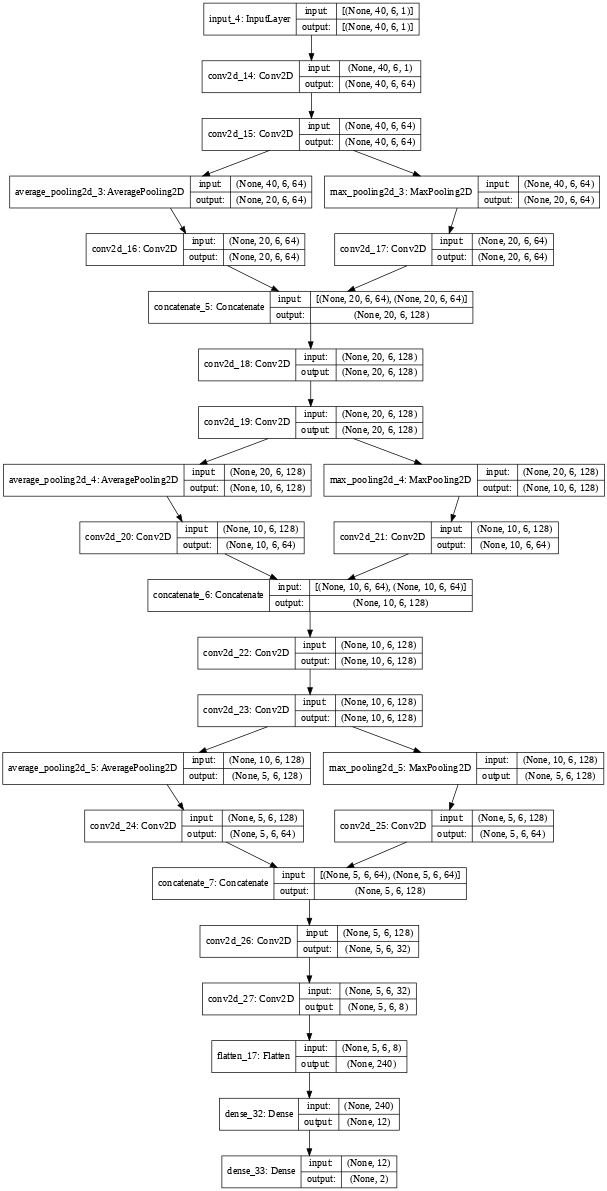

In [31]:
#from keras.utils import plot_model
#print(model.summary()) #Вывод структуры модели
utils.plot_model(model, dpi=50, show_shapes=True, show_layer_names=True)

## Обучение

In [32]:
model.compile(optimizer=Adam(learning_rate = 3e-05),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy']) 

early_stopping = EarlyStopping(monitor = 'val_categorical_accuracy', patience = 12, verbose = 0, 
                               restore_best_weights = True, mode='max')

#reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor=0.8, patience=4, min_lr=1e-07, verbose = 0)
reduce_lr = ReduceLROnPlateau(monitor = 'val_categorical_accuracy', factor=0.8, patience=4, min_lr=1e-07, verbose = 0, mode='max')

checkpoint = ModelCheckpoint(ticker + '_Conc_1h.h5', monitor='val_categorical_accuracy', verbose = 1,
                             save_best_only = True, mode='max')

# fit model
history = model.fit(ds.train(),
                    epochs=500, verbose = 0,
                    validation_data=ds.val(),
                    callbacks = [early_stopping, checkpoint]#, reduce_lr]
                    )



Epoch 00001: val_categorical_accuracy improved from -inf to 0.61346, saving model to POLY.ME_Conc_1h.h5

Epoch 00002: val_categorical_accuracy improved from 0.61346 to 0.66558, saving model to POLY.ME_Conc_1h.h5

Epoch 00003: val_categorical_accuracy improved from 0.66558 to 0.71227, saving model to POLY.ME_Conc_1h.h5

Epoch 00004: val_categorical_accuracy improved from 0.71227 to 0.74593, saving model to POLY.ME_Conc_1h.h5

Epoch 00005: val_categorical_accuracy improved from 0.74593 to 0.75136, saving model to POLY.ME_Conc_1h.h5

Epoch 00006: val_categorical_accuracy improved from 0.75136 to 0.79045, saving model to POLY.ME_Conc_1h.h5

Epoch 00007: val_categorical_accuracy improved from 0.79045 to 0.81542, saving model to POLY.ME_Conc_1h.h5

Epoch 00008: val_categorical_accuracy improved from 0.81542 to 0.82519, saving model to POLY.ME_Conc_1h.h5

Epoch 00009: val_categorical_accuracy improved from 0.82519 to 0.84582, saving model to POLY.ME_Conc_1h.h5

Epoch 00010: val_categorical_a

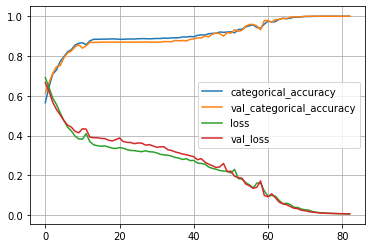

In [33]:
plt.figure(figsize=(6,4))
plt.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='val_categorical_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.grid()
plt.show()

# Проверка модели

In [34]:
pred = model.predict(ds.test()
                             #start_index=data.shape[0]-test_window,
                             #end_index=data.shape[0]-1)
                             )
ddd = ds.test_prep_dec(pred)

In [44]:
# Cигналы нейронки
ddd

,Open,High,Low,Close,Signal
2021-05-05 18:30:00,1635.400024,1638.099976,1634.500000,1637.300049,-1.0
2021-05-06 09:30:00,1588.900024,1610.599976,1581.599976,1590.199951,1.0
2021-05-06 10:30:00,1589.800049,1604.500000,1588.099976,1599.599976,1.0
2021-05-06 11:30:00,1599.500000,1599.599976,1590.500000,1594.599976,1.0
2021-05-06 12:30:00,1594.599976,1597.099976,1590.400024,1592.400024,1.0
...,...,...,...,...,...
2021-06-04 14:30:00,1728.800049,1731.199951,1724.900024,1725.099976,1.0
2021-06-04 15:30:00,1725.199951,1759.800049,1725.199951,1755.400024,1.0
2021-06-04 16:30:00,1756.000000,1759.900024,1753.900024,1759.000000,1.0
2021-06-04 17:30:00,1758.800049,1763.000000,1753.199951,1755.300049,1.0


In [40]:
# Стратегия только Long (подключен класс стратегии LS)
bt = Backtest(ddd, LS, cash=100000, commission=.004, trade_on_close=True)
stats = bt.run()
bt.plot(plot_volume=True, relative_equity=True)
stats

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Superimposed OHLC plot matches the original plot. Skipping.
  after removing the cwd from sys.path.


Start                     2021-05-05 18:30:00
End                       2021-06-04 18:30:00
Duration                     30 days 00:00:00
Exposure Time [%]                     60.6335
Equity Final [$]                       125356
Equity Peak [$]                        125618
Return [%]                            25.3555
Buy & Hold Return [%]                 7.12758
Return (Ann.) [%]                     1089.35
Volatility (Ann.) [%]                 223.804
Sharpe Ratio                          4.86743
Sortino Ratio                         306.741
Calmar Ratio                          452.945
Max. Drawdown [%]                    -2.40504
Avg. Drawdown [%]                   -0.388913
Max. Drawdown Duration        2 days 20:00:00
Avg. Drawdown Duration        0 days 10:00:00
# Trades                                   11
Win Rate [%]                              100
Best Trade [%]                        3.52177
Worst Trade [%]                      0.310218
Avg. Trade [%]                    

In [41]:
# Стратегия Long & Short (подключен класс стратегии LnS)
bt = Backtest(ddd, LnS, cash=100000, commission=.004, trade_on_close=True)
stats = bt.run()
bt.plot(plot_volume=True, relative_equity=True)
stats

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Superimposed OHLC plot matches the original plot. Skipping.
  after removing the cwd from sys.path.


Start                     2021-05-05 18:30:00
End                       2021-06-04 18:30:00
Duration                     30 days 00:00:00
Exposure Time [%]                      99.095
Equity Final [$]                       129474
Equity Peak [$]                        129744
Return [%]                            29.4743
Buy & Hold Return [%]                 7.12758
Return (Ann.) [%]                     1594.89
Volatility (Ann.) [%]                 404.962
Sharpe Ratio                          3.93838
Sortino Ratio                         172.938
Calmar Ratio                           355.21
Max. Drawdown [%]                    -4.49001
Avg. Drawdown [%]                   -0.662872
Max. Drawdown Duration        6 days 15:00:00
Avg. Drawdown Duration        0 days 18:00:00
# Trades                                   21
Win Rate [%]                          90.4762
Best Trade [%]                         3.4521
Worst Trade [%]                      -1.40194
Avg. Trade [%]                    

In [42]:
# Проверка по идеальной разметке стратегия Long & Short
bt = Backtest(data[ds.test_start_index + ensemble:], LnS, cash=100000, commission=.004, trade_on_close=True)
stats = bt.run()
bt.plot(plot_volume=True, relative_equity=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Superimposed OHLC plot matches the original plot. Skipping.
  after removing the cwd from sys.path.


In [43]:
# Последние сигналы разметки
data[ds.test_start_index + ensemble:][-15:]

,Date,Open,High,Low,Close,Signal
Datetime,,,,,,
2021-06-03 14:30:00,2021-06-03 14:30:00,1764.800049,1764.800049,1753.300049,1757.400024,-1.0
2021-06-03 15:30:00,2021-06-03 15:30:00,1756.599976,1757.500000,1745.699951,1753.000000,-1.0
2021-06-03 16:30:00,2021-06-03 16:30:00,1750.699951,1752.099976,1736.000000,1745.000000,-1.0
2021-06-03 17:30:00,2021-06-03 17:30:00,1745.000000,1749.800049,1739.199951,1742.900024,1.0
2021-06-03 18:30:00,2021-06-03 18:30:00,1743.000000,1747.000000,1741.699951,1747.000000,1.0
2021-06-04 09:30:00,2021-06-04 09:30:00,1758.599976,1758.599976,1743.199951,1752.000000,1.0
2021-06-04 10:30:00,2021-06-04 10:30:00,1752.199951,1754.000000,1732.400024,1733.000000,1.0
2021-06-04 11:30:00,2021-06-04 11:30:00,1732.900024,1732.900024,1706.400024,1722.900024,1.0
2021-06-04 12:30:00,2021-06-04 12:30:00,1723.300049,1725.599976,1715.900024,1721.699951,1.0
